# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [20]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import DataScienceHelperLibrary as dsh

from IPython.display import HTML
from importlib import reload


# magic word for producing visualizations in notebook
%matplotlib inline

In [25]:
reload(dsh)

<module 'DataScienceHelperLibrary' from 'P:\\_Ausbildung\\#Udacity\\#Lession 11 - Capestone\\Repro\\CustomerSegmentation_Bertelsmann_Avarto\\DataScienceHelperLibrary.py'>

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
# load in the data
#azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
#customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

from sqlalchemy import create_engine

engine = create_engine('sqlite:///{}'.format('CustomerData.db'))

In [4]:
azdias = pd.read_sql_table('azdias', engine)
customers = pd.read_sql_table('customers', engine)

In [ ]:
azdiasTrain = pd.read_sql_table('azdiastrain', engine)
customersTest = pd.read_sql_table('customerstest', engine)

As the data is loaded, let's have a quick look at the first top rows, analyze number of missing nan values in columns and plot it.

In [5]:
dsh.TailHead(azdias)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
5,910244,3,1.0,10.0,NaN,NaN,NaN,NaN,10.0,5.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1
6,910248,-1,9.0,0.0,NaN,NaN,NaN,NaN,NaN,4.0,...,2.0,7.0,10.0,10.0,3.0,9.0,5.0,4,2,2
7,910261,-1,1.0,14.0,NaN,NaN,NaN,NaN,14.0,6.0,...,2.0,10.0,12.0,9.0,5.0,9.0,1.0,1,1,1
8,645145,-1,9.0,16.0,NaN,NaN,NaN,NaN,16.0,2.0,...,4.0,8.0,11.0,8.0,5.0,8.0,1.0,6,1,3
9,645153,-1,5.0,17.0,NaN,NaN,NaN,NaN,17.0,9.0,...,4.0,1.0,1.0,1.0,4.0,3.0,7.0,4,2,3


In [6]:
dsh.AnalyzeNanColumns(azdias)

-------------------- Analysis of Columns with NaN values --------------------
Columns having all values: 93, 25.41%
LNR, type: int64                         0.0
AGER_TYP, type: int64                    0.0
D19_BANKEN_ANZ_12, type: int64           0.0
D19_BANKEN_ANZ_24, type: int64           0.0
D19_BANKEN_DATUM, type: int64            0.0
D19_BANKEN_DIREKT, type: int64           0.0
D19_BANKEN_GROSS, type: int64            0.0
D19_BANKEN_LOKAL, type: int64            0.0
D19_BANKEN_OFFLINE_DATUM, type: int64    0.0
D19_BANKEN_ONLINE_DATUM, type: int64     0.0
D19_BANKEN_REST, type: int64             0.0
D19_BEKLEIDUNG_GEH, type: int64          0.0
D19_BEKLEIDUNG_REST, type: int64         0.0
D19_BILDUNG, type: int64                 0.0
D19_BIO_OEKO, type: int64                0.0
D19_BUCH_CD, type: int64                 0.0
D19_DIGIT_SERV, type: int64              0.0
D19_DROGERIEARTIKEL, type: int64         0.0
D19_ENERGIE, type: int64                 0.0
D19_FREIZEIT, type: int64    

ALTER_KIND4                    99.864792
ALTER_KIND3                    99.307691
ALTER_KIND2                    96.690047
ALTER_KIND1                    90.904837
EXTSEL992                      73.399639
KK_KUNDENTYP                   65.596749
ALTERSKATEGORIE_FEIN           29.504130
D19_LETZTER_KAUF_BRANCHE       28.849522
D19_LOTTO                      28.849522
D19_VERSI_ONLINE_QUOTE_12      28.849522
D19_BANKEN_ONLINE_QUOTE_12     28.849522
D19_SOZIALES                   28.849522
D19_GESAMT_ONLINE_QUOTE_12     28.849522
D19_KONSUMTYP                  28.849522
D19_TELKO_ONLINE_QUOTE_12      28.849522
D19_VERSAND_ONLINE_QUOTE_12    28.849522
KBA05_MOTOR                    14.959701
KBA05_MOD8                     14.959701
KBA05_MOD4                     14.959701
KBA05_MOD3                     14.959701
dtype: float64


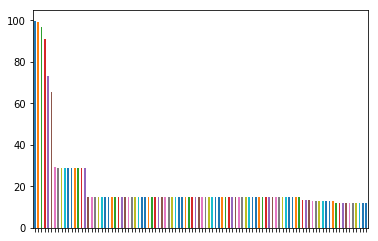

In [7]:
def PrintIsNullDist(df, top = 100, axis = 0, toplabels = 20):
    dfPlt = azdias.isnull().sum(axis = axis).sort_values(ascending = False)[:top]
    dividend = df.shape[0]
    if axis == 1:
        dividend = df.shape[1]
    
    dfPlt = dfPlt.apply(lambda x: (x * 100) / dividend)
    
    ax = dfPlt.plot(kind = 'bar')

    _ = ax.set_xticklabels([])
    print(dfPlt[:toplabels])
    
    return dfPlt
_ = PrintIsNullDist(azdias)

The analysis shows that there are columns:

- Columns having > 50% and <= 70% missing values: 1, 0.27%
    - KK_KUNDENTYP, type: float64    0.655967

- Columns having > 70% missing values: 5, 1.37%
    - ALTER_KIND1, type: float64    0.909048
    - ALTER_KIND2, type: float64    0.966900
    - ALTER_KIND3, type: float64    0.993077
    - ALTER_KIND4, type: float64    0.998648
    - EXTSEL992, type: float64      0.733996

This large amount of missing values is not helpuf and I will drop them later. 

Now I load the attribute files to get valid values for each column and convert - if possible - unknown/missing values (indicated by -1, 0) to nan.

Then I check again how many nan values are present in all columns and depending on that, I determine the limit when to drop columns.

For further "configurations" I store data in the following config class. The attributes are filled based on findings in azdias and used in the cleaning function.

Before adding columns to the collection, I load the attribute file and check if there are columns that are not described to have a look at them if there is something special about them.

Then I convert mising values - if present (indicated by 0, -1) - to np.nan and then fill **CleanConfig.ColumnsToDrop**.

In [8]:
def ReadAttributeFiles():
    xlAttributes = pd.read_excel('DIAS Attributes - Values 2017.xlsx')
    xlInfos = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx')
    return xlAttributes, xlInfos

In [9]:
a, b = ReadAttributeFiles()

b.head()

,Unnamed: 0,Information level,Attribute,Description,Additional notes
0,NaN,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,NaN,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,NaN,ANREDE_KZ,gender,NaN
3,NaN,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [11]:
class CleanConfig:
    
    def IsNone(inp):
        return dsh.IsNullOrEmpty(inp)
    
    # The objects are set/filled in the same order they are listed up 
    
    ColumnsToDrop = []  
    
    RowsToTropByMisNan = 0.0
    
    ColumnValues = {}
    
    ColumnsWithoutInfo = []
    
    AttributesNotInAzdias = []
    
    AttributeLevelsNotInAzdias  = []

In [15]:
class ColumnValues:
    def __init__(self, columnName):
        self.ColumnName = columnName
        self.UnknownValues = []
        self.KnownValues = []
        self.DType = None
    
    def Add(self, isunknown, value):
        if isunknown:
            self.UnknownValues.append(value)
        else:
            self.KnownValues.append(value)
    
    def IsNumeric(self):
        return self.DType in dsh.NumberTypes

def LoadColumnsAndValuesInfos(df):
    
    xlAttributes, xlInfos = ReadAttributeFiles()
    currentAttrib = ''
    CleanConfig.ColumnValues = {}
    CleanConfig.ColumnsWithoutInfo = []
    count = 0
    colVal = None
    
    # iterate over all rows
    
    for ind, row in xlAttributes.iterrows():
        # remember the current row
        if row['Attribute'] is not np.nan:
            currentAttrib = row['Attribute']
            
            if currentAttrib not in df.columns:
                CleanConfig.AttributesNotInAzdias.append(currentAttrib)
                colVal = None
                continue
            
            if colVal is not None:
                CleanConfig.ColumnValues[colVal.ColumnName] = colVal
                
            colVal = ColumnValues(currentAttrib)
            colVal.DType = df[currentAttrib].dtype
        # When row is not contained in azdias
        if colVal is None:
            continue
        
        isunknown = 'unknown' in str(row['Meaning'])
        currentVal = row['Value']

        # if value is a number, then add and continue
        # else try to split and parse to float
        # else add the original string value.
        try:
            if type(currentVal) in dsh.NumberTypes:

                #dirAttributeValues[currentAttrib].append(currentVal)
                colVal.Add(isunknown, currentVal)

                continue

            # skip numerical columns
            if '.' in currentVal:
                continue

            if ',' in currentVal:
                splt = currentVal.split(',')
                for val in splt:
                    try:
                        colVal.Add(isunknown, float(val.strip()))
                    except:
                        colVal.Add(isunknown, val)
       
        except:
            print('Error while processing row {0} with value "{}"'.format(ind, currentVal))
    
    
    for col in df.columns:
        if not col in CleanConfig.ColumnValues.keys():
            colVal = ColumnValues(col)
            colval.DType = df[col].dtype
            CleanConfig.ColumnsWithoutInfo.append(col)
            CleanConfig.ColumnValues[colVal.ColumnName] = colVal
            
    
    for ind, row in xlInfos.iterrows():
        
        col = row['Attribute']
        if col is np.nan:
            continue
        
        for colsplt in col.split(' '):
            if len(colsplt) == 0:
                continue
                
            if colsplt in CleanConfig.ColumnValues.keys():
                continue
                
            if colsplt not in df.columns:
                CleanConfig.AttributeLevelsNotInAzdias.append(colsplt)
                continue

            cv = ColumnValues(colsplt)
            cv.DType = df[colsplt].dtype

            CleanConfig.ColumnValues[colsplt] = cv
    
    print('Columns and attributes successfully loaded')
    
LoadColumnsAndValuesInfos(azdias)

ValueError: cannot switch from manual field specification to automatic field numbering

Now I check which columns are not described

In [480]:
azdias[CleanConfig.ColumnsWithoutInfo].head()

,LNR,AKT_DAT_KL,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_KINDER,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,...,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,WOHNLAGE,ZABEOTYP
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
1,910220,9.0,NaN,NaN,NaN,NaN,21.0,0.0,12.0,3.0,...,3.0,1.0,0.0,0.0,4.0,8.0,11.0,10.0,4.0,5
2,910225,9.0,NaN,NaN,NaN,NaN,17.0,0.0,7.0,3.0,...,5.0,0.0,1.0,0.0,2.0,9.0,9.0,6.0,2.0,5
3,910226,1.0,NaN,NaN,NaN,NaN,13.0,0.0,2.0,2.0,...,5.0,0.0,0.0,1.0,0.0,7.0,10.0,11.0,7.0,3
4,910241,1.0,NaN,NaN,NaN,NaN,14.0,0.0,3.0,4.0,...,3.0,0.0,1.0,0.0,2.0,3.0,5.0,4.0,3.0,4


In [440]:
print('Data types of undescribed columns: ', set([azdias[col].dtype for col in azdias.columns]))

Data types of undescribed columns:  {dtype('int64'), dtype('float64'), dtype('O')}


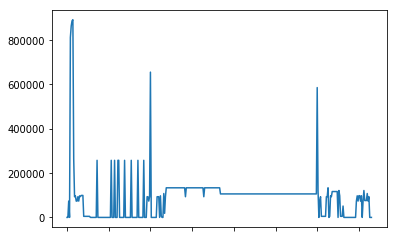

In [485]:
azdias[missingInfoColumns].isnull().sum().plot()

Havig a closer look to the columns, for most of the columns I have a feeling for what they could stand for (because I am german).

But one column is definitely out of interest: LNR. LNR stands for "laufende Nummer" ("running number") like an index.
So I add this column to the list of columns that I drop later.

In [ ]:
CleanConfig.ColumnsToDrop.append('LNR')

In [263]:
def ConvertMissingValuesToNan(inpDf):
    df = inpDf.copy(deep = True)
    attribVals = ExtractAttributesAndValues()
    
    for col in df.columns:
        if not col in attribVals.keys():
            continue
        try:
            df[col] = df[col].apply(lambda x: np.nan if x in attribVals[col] else x)
        except:
            print('Error applying "lambda x: np.nan if x < 1 else x" to dataframe')
    
    return df    

ALTER_KIND4                    99.864792
ALTER_KIND3                    99.307691
ALTER_KIND2                    96.690047
ALTER_KIND1                    90.904837
EXTSEL992                      73.399639
KK_KUNDENTYP                   65.596749
ALTERSKATEGORIE_FEIN           29.504130
D19_LETZTER_KAUF_BRANCHE       28.849522
D19_LOTTO                      28.849522
D19_VERSI_ONLINE_QUOTE_12      28.849522
D19_BANKEN_ONLINE_QUOTE_12     28.849522
D19_SOZIALES                   28.849522
D19_GESAMT_ONLINE_QUOTE_12     28.849522
D19_KONSUMTYP                  28.849522
D19_TELKO_ONLINE_QUOTE_12      28.849522
D19_VERSAND_ONLINE_QUOTE_12    28.849522
KBA05_MOTOR                    14.959701
KBA05_MOD8                     14.959701
KBA05_MOD4                     14.959701
KBA05_MOD3                     14.959701
dtype: float64


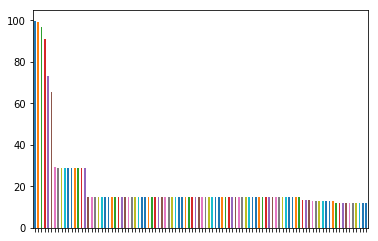

In [270]:
azMissToNan = ConvertMissingValuesToNan(azdias)
azMissToNan = PrintIsNullDist(azMissToNan)

In [ ]:
for dropCol in list(dsh.GetColumnHavingNanPercent(
    azdias, percent = 0.3).columns):
    print('Adding column: ', dropCol)
    CleanConfig.ColumnsToDrop.append(dropCol)

azdias.columns.sort_values()

In [203]:
def RemoveOutlinerColumns(dfInput):
    return dsh.RemoveColumnsByWildcard(dfInput, CleanConfig.ColumnsToDrop)

Now I clean the dataframe(s) by number of missing values in each row:

In [334]:
def CalcMeanOutlinerRows(dfInput):
    dfsum = dfInput.isnull().sum(axis = 1) / dfInput.shape[1]
    
    return dfsum

In [335]:
dfsum = CalcMeanOutlinerRows(azdias)

In [352]:
print(dfsum.shape[0])
print(dfsum.shape[0] - dfsum[dfsum <= 0.2].shape[0], (dfsum.shape[0] - dfsum[dfsum <= 0.2].shape[0]) / dfsum.shape[0])
print(dfsum.shape[0] - dfsum[dfsum <= 0.3].shape[0], (dfsum.shape[0] - dfsum[dfsum <= 0.3].shape[0]) / dfsum.shape[0])
print(dfsum.shape[0] - dfsum[dfsum <= 0.4].shape[0], (dfsum.shape[0] - dfsum[dfsum <= 0.4].shape[0]) / dfsum.shape[0])

891221
118087 0.13250024404721164
105805 0.11871915046885116
99264 0.11137978122149277


In [345]:
dfsum[dfsum.between(0.2, 0.4)].shape

(18823,)

I decide to keep rows by <= 20% of missing values. 118087 rows would be droppen (circa 13.25% of the rows) because I don't see any advantage of considering rows with more missing values. Considering 2% more rows (18823) with up to 40% is missing values is not useful.

In [347]:
CleanConfig.RowsToTropByMisNan = 0.2

In [356]:
def RemoveOutlinerRows(dfInput):
    return dfInput[CalcMeanOutlinerRows(dfInput) <= CleanConfig.RowsToTropByMisNan]

def GetOutlinerRows(dfInput):
    return dfInput[CalcMeanOutlinerRows(dfInput) > CleanConfig.RowsToTropByMisNan]

In [357]:
# TODO: Show for some interesing columns how the missing values are distributed

### Encoding features

In [442]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,0,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,0,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,0,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [35]:
def EncodeColumns(dfInput):
    df = dfInput.copy(deep = True)
    
    dirColReplacements = {}
    
    for col in df.columns:
        if col in CleanConfig.ColumnsToDrop:
            continue
        
        if col in CleanConfig.ColumnValues.keys():
            colval = CleanConfig.ColumnValues[col]
            
            if colval.IsNumeric():
                continue

            lenKnown = len(colval.KnownValues)

            if lenKnown == 0:
                colval.KnownValues = [print(x) for x in df[col].unique() if not CleanConfig.IsNone(x)]

            # Binary
            if lenKnown == 2:
                df = dsh.ApplyBinaryEncoding(df[col])
            else:
                df = dsh.ApplyOneHotEncoding(df, columns = [col])
        
        #column was not contained in value description
        if df[col].dtype in dsh.NumberTypes:
            continue
        
        uqv = [x for x in df[col].unique() if not CleanConfig.IsNone(x)]
        lenKnown = len(uqv)
        
        if lenKnown == 2:
            df = dsh.ApplyBinaryEncoding(df[col])
        else:
            df = dsh.ApplyOneHotEncoding(df, columns = [col])
        
    return df

In [487]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,0,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,0,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,0,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [156]:
# the main clean function

def CleanFile(inpDf):
    
    df = inpDf.copy(deep = True)
    
    # remove columns we don't want
    df = RemoveColumnsByWildcard(df, CleanConfig.ColumnsToDrop)
    
    # convert missing values to nan
    df = ConvertMissingValuesToNan(df)
    
    # drop columns and rows by % of missing values
    df = RemoveOutlinerColumns(df)
    df = RemoveOutlinerRows(df)
    
    df = EncodeColumns(df)
    
    return df
    
    


In [158]:
CleanFile(azdias)

-------------------- Start finding and removing columns matchting to wildcards: ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KK_KUNDENTYP', 'LNR'] --------------------
Columns found to remove:  ['LNR', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KK_KUNDENTYP']
-------------------- Finished removing columns matchting to wildcards --------------------


,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,0,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,0,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,2,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,0,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [111]:
CleanFile(azdias)

-------------------- Dataframe analysis started --------------------
Shape:  (891221, 366)
Number of duplicate rows:  0
-------------------- Analysis of Columns with NaN values --------------------
Columns having all values: 94, 25.68%
LNR, type: int64                         0.0
AGER_TYP, type: int64                    0.0
ALTER_HH, type: float64                  0.0
D19_BANKEN_ANZ_12, type: int64           0.0
D19_BANKEN_ANZ_24, type: int64           0.0
D19_BANKEN_DATUM, type: int64            0.0
D19_BANKEN_DIREKT, type: int64           0.0
D19_BANKEN_GROSS, type: int64            0.0
D19_BANKEN_LOKAL, type: int64            0.0
D19_BANKEN_OFFLINE_DATUM, type: int64    0.0
D19_BANKEN_ONLINE_DATUM, type: int64     0.0
D19_BANKEN_REST, type: int64             0.0
D19_BEKLEIDUNG_GEH, type: int64          0.0
D19_BEKLEIDUNG_REST, type: int64         0.0
D19_BILDUNG, type: int64                 0.0
D19_BIO_OEKO, type: int64                0.0
D19_BUCH_CD, type: int64                 0.0

0.0     731242
1.0      55350
2.0      24445
3.0       5376
4.0       1057
5.0        190
6.0         47
7.0         10
9.0          3
11.0         1
8.0          1
Name: ANZ_KINDER, dtype: int64
********************  ********************
********************  ********************
More than 20 different values:  30
Name:  ANZ_PERSONEN , dtype:  int64
********************  ********************
********************  ********************
More than 20 different values:  268
Name:  ANZ_STATISTISCHE_HAUSHALTE , dtype:  int64
********************  ********************
********************  ********************
0.0    814542
1.0      2970
2.0       202
3.0         5
4.0         2
6.0         1
Name: ANZ_TITEL, dtype: int64
********************  ********************
********************  ********************
4.0    311339
3.0    254988
2.0    135662
1.0     56767
5.0     35090
9.0       159
Name: ARBEIT, dtype: int64
********************  ********************
********************  *************

********************  ********************
0    768381
6     90968
7     25319
5      3810
3      2465
4       184
2        87
1         7
Name: D19_HANDWERK, dtype: int64
********************  ********************
********************  ********************
0    713100
6    100720
3     31024
5     20748
7     10278
2      7476
1      4133
4      3742
Name: D19_HAUS_DEKO, dtype: int64
********************  ********************
********************  ********************
0    749365
6     79320
7     22597
3     16402
5     13398
2      5842
4      3224
1      1073
Name: D19_KINDERARTIKEL, dtype: int64
********************  ********************
********************  ********************
9.0    254296
1.0    117912
4.0     78262
6.0     56562
3.0     53330
2.0     49324
5.0     24422
Name: D19_KONSUMTYP, dtype: int64
********************  ********************
********************  ********************
8    260285
9    257113
1    144570
2     91423
4     75752
3     62078
Name: D19_KONSUM

********************  ********************
6.0    201009
5.0    161209
2.0    139087
4.0    130716
1.0     84051
3.0     81409
Name: EWDICHTE, dtype: int64
********************  ********************
********************  ********************
More than 20 different values:  56
Name:  EXTSEL992 , dtype:  int64
********************  ********************
********************  ********************
5    234508
1    210812
2    161286
4    143597
3    141018
Name: FINANZ_ANLEGER, dtype: int64
********************  ********************
********************  ********************
3    235184
5    183918
2    171847
4    157168
1    143104
Name: FINANZ_HAUSBAUER, dtype: int64
********************  ********************
********************  ********************
3    256276
5    168863
4    167182
2    159313
1    139587
Name: FINANZ_MINIMALIST, dtype: int64
********************  ********************
********************  ********************
1    250213
4    201223
2    153051
5    146380
3    140

2.0    380095
1.0    208542
3.0    154474
9.0     14786
Name: KBA05_KRSZUL, dtype: int64
********************  ********************
********************  ********************
3.0    274856
4.0    160522
2.0    160221
1.0     78285
5.0     69227
9.0     14786
Name: KBA05_KW1, dtype: int64
********************  ********************
********************  ********************
3.0    306246
2.0    155172
4.0    152081
5.0     64938
1.0     64674
9.0     14786
Name: KBA05_KW2, dtype: int64
********************  ********************
********************  ********************
1.0    233518
0.0    206843
2.0    160776
3.0     80358
4.0     61616
9.0     14786
Name: KBA05_KW3, dtype: int64
********************  ********************
********************  ********************
3.0    209157
5.0    195036
2.0    185708
4.0    102197
1.0     51013
9.0     14786
Name: KBA05_MAXAH, dtype: int64
********************  ********************
********************  ********************
1.0    256917
4.0    18

3.0    356794
2.0    166960
4.0    160793
1.0     52194
5.0     48680
Name: KBA13_BJ_2006, dtype: int64
********************  ********************
********************  ********************
3.0    274885
2.0    170564
0.0    134372
4.0     86070
5.0     69750
1.0     49780
Name: KBA13_BJ_2008, dtype: int64
********************  ********************
********************  ********************
3.0    286198
1.0    119909
2.0    118034
0.0    101115
4.0     88293
5.0     71872
Name: KBA13_BJ_2009, dtype: int64
********************  ********************
********************  ********************
3.0    346193
4.0    176871
2.0    139903
5.0     83249
1.0     39205
Name: KBA13_BMW, dtype: int64
********************  ********************
********************  ********************
3.0    268319
2.0    178378
0.0    138711
4.0     81885
1.0     60025
5.0     58103
Name: KBA13_CCM_0_1400, dtype: int64
********************  ********************
********************  ********************
3.0    29

3.0    278290
2.0    161652
0.0    139756
4.0     88055
5.0     75224
1.0     42444
Name: KBA13_KMH_250, dtype: int64
********************  ********************
********************  ********************
1.0    674722
3.0    100548
2.0     10151
Name: KBA13_KMH_251, dtype: int64
********************  ********************
********************  ********************
3.0    324094
2.0    172621
4.0    142200
1.0     91812
5.0     54634
0.0        60
Name: KBA13_KRSAQUOT, dtype: int64
********************  ********************
********************  ********************
3.0    337010
2.0    167559
4.0    162124
1.0     65798
5.0     52872
0.0        58
Name: KBA13_KRSHERST_AUDI_VW, dtype: int64
********************  ********************
********************  ********************
3.0    345264
4.0    165044
2.0    153245
5.0     74315
1.0     47495
0.0        58
Name: KBA13_KRSHERST_BMW_BENZ, dtype: int64
********************  ********************
********************  ********************
3.

3.0    361449
2.0    167076
4.0    158150
1.0     50939
5.0     47807
Name: KBA13_VORB_1, dtype: int64
********************  ********************
********************  ********************
3.0    359262
2.0    173047
4.0    151120
1.0     61834
5.0     40158
Name: KBA13_VORB_1_2, dtype: int64
********************  ********************
********************  ********************
3.0    363866
2.0    166317
4.0    162515
5.0     49491
1.0     43232
Name: KBA13_VORB_2, dtype: int64
********************  ********************
********************  ********************
3.0    264685
2.0    177458
0.0    143284
4.0     81176
5.0     64131
1.0     54687
Name: KBA13_VORB_3, dtype: int64
********************  ********************
********************  ********************
3.0    336588
2.0    171175
4.0    149018
1.0     71506
5.0     57134
Name: KBA13_VW, dtype: int64
********************  ********************
********************  ********************
3.0    65151
2.0    62564
5.0    48038
4.0 

7    211377
4    207128
3    150801
1    108130
5     79566
2     73127
6     61092
Name: SEMIO_REL, dtype: int64
********************  ********************
********************  ********************
2    244714
6    136205
5    121786
3    118889
7    117378
4     90161
1     62088
Name: SEMIO_SOZ, dtype: int64
********************  ********************
********************  ********************
3    226571
4    174203
2    132657
5    117378
1     96775
7     76133
6     67504
Name: SEMIO_TRADV, dtype: int64
********************  ********************
********************  ********************
2    204333
6    141714
5    135205
7    134756
4    122982
1    120437
3     31794
Name: SEMIO_VERT, dtype: int64
********************  ********************
********************  ********************
 1    254761
 2    207463
 3    190219
 0    127582
-1    111196
Name: SHOPPER_TYP, dtype: int64
********************  ********************
********************  ********************
0.0    810834


## Preparing for model - Feature transformation

In [ ]:
oneHotCopy = azdias.copy(deep = True)

imputer = preprocessing.Imputer(missing_values = 'NaN', strategy = 'median', axis = 0)

impTfOneHot = imputer.fit_transform(oneHotCopy)

impTfOneHotDf = pd.DataFrame(impTfOneHot, columns = list(oneHotCopy.columns))

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')